In [1]:
%load_ext autoreload
%autoreload 2
# %cd "../deepshape"

In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Import all curve reparametrization functions
from deepshape.curves import *

# Set plotting Parameters
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

In [5]:
# Define Curves 
c1 = Infinity  # See deepshape.curves.curves for definition.
c2 = c1.compose(g)

# Analytic diffeomorphism
g = LogStepDiff


# Get Qmaps (reparametrize c1 into c2(x) = c1(g(x)))
# q, r = Qmap(c2), Qmap(c1)
q, r = SRVT(c2), SRVT(c1)

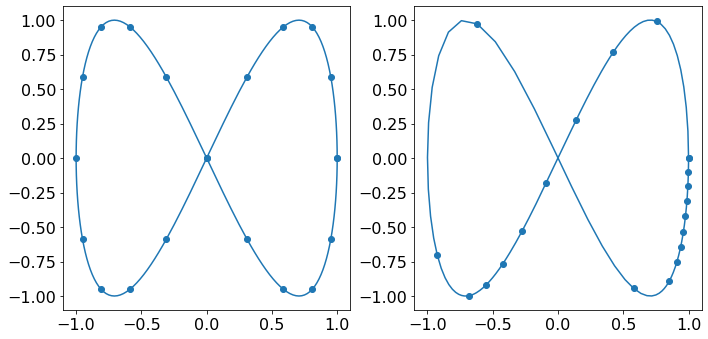

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_curve(c1, dotpoints=21, ax=plt.gca())
plt.subplot(122)
plot_curve(c2, dotpoints=21, ax=plt.gca())
plt.tight_layout()
plt.show()

In [7]:
# Build network of L layers with N_l basis functions per layer
RN = ReparametrizationNetwork(5, 5, init_scale=0., layer_type=PalaisLayer)

# Choose and configure optimizer.
optimizer = optim.LBFGS(RN.parameters(), lr=0.1, max_iter=200, line_search_fn='strong_wolfe')

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, threshold=0.,
    threshold_mode='rel', cooldown=10, min_lr=1e-6, eps=1e-08,
    verbose=True)

# Train with BFGS-optimizer
error = train_bfgs(q, r, RN, optimizer, scheduler=scheduler, iterations=1, log_every=1)

[Iter     1] loss: 12.87349
[Iter     2] loss: 11.65818
[Iter     3] loss: 11.13464
[Iter     4] loss: 9.58347
[Iter     5] loss: 9.49022
[Iter     6] loss: 8.69375
[Iter     7] loss: 5.08364
[Iter     8] loss: 4.08674
[Iter     9] loss: 3.36837
[Iter    10] loss: 2.71213
[Iter    11] loss: 2.20541
[Iter    12] loss: 1.83849
[Iter    13] loss: 1.55906
[Iter    14] loss: 1.33341
[Iter    15] loss: 1.14367
[Iter    16] loss: 0.97985
[Iter    17] loss: 0.83605
[Iter    18] loss: 0.70903
[Iter    19] loss: 0.23616
[Iter    20] loss: 0.22778
[Iter    21] loss: 0.16590
[Iter    22] loss: 0.15378
[Iter    23] loss: 0.14288
[Iter    24] loss: 0.09771
[Iter    25] loss: 0.09646
[Iter    26] loss: 0.09199
[Iter    27] loss: 0.09072
[Iter    28] loss: 0.08289
[Iter    29] loss: 0.08151
[Iter    30] loss: 0.07171
[Iter    31] loss: 0.06949
[Iter    32] loss: 0.06174
[Iter    33] loss: 0.06053
[Iter    34] loss: 0.05648
[Iter    35] loss: 0.05609
[Iter    36] loss: 0.05486
[Iter    37] loss: 0.0547

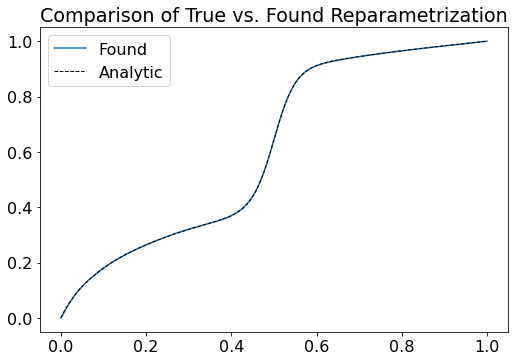

In [8]:
x, z, _, _, _ = get_plot_data(q, r, RN, 1024)

# Plot Diffeomorphism...
plt.figure(figsize=(8.4, 5.6))
plt.plot(x, z, label="Found", lw=1.5)
plt.plot(x, g(x), label="Analytic", ls="--", c="black", lw=1)
plt.title("Comparison of True vs. Found Reparametrization")
plt.legend()
plt.show()

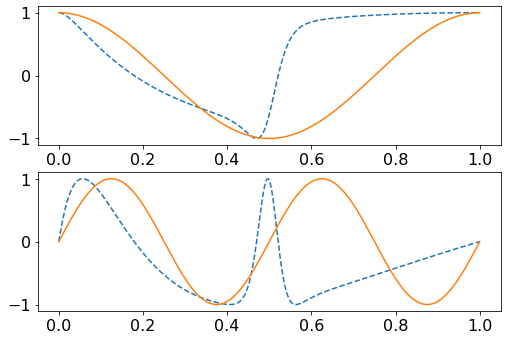

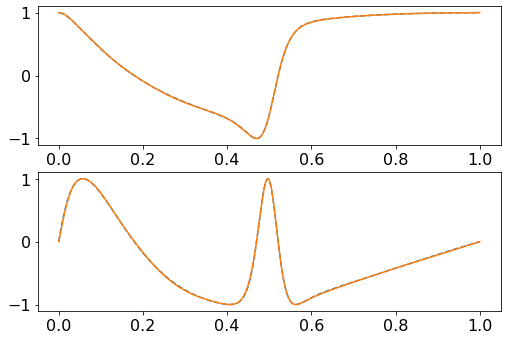

In [9]:
# Get coordinates befora and after reparametrization
C1, C2, C3 = c1(x), c2(x), c1(z)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C1[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C1[:, 1])
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8.3, 5.6))
ax1.plot(x, C2[:, 0], ls="dashed")
ax1.plot(x, C3[:, 0])

ax2.plot(x, C2[:, 1], ls="dashed")
ax2.plot(x, C3[:, 1])
plt.show()